# day 3-2

このノートブックの実行例は[こちら(HTML版)](lecture-gssm2025/notebooks-sample/day-3-2.html)で確認できます

---

In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import numpy as np

# 再現性のために乱数を固定する
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)

## 0. 準備

### 0.1 必要なパッケージのインストール

In [2]:
%%capture
!sudo apt-get update
!sudo apt-get install -y automake autoconf perl libtool graphviz libgraphviz-dev
!pip install -U japanize_matplotlib pyvis pygraphviz mca

教材のダウンロード

In [3]:
!git clone https://github.com/haradatm/lecture-gssm2025

Cloning into 'lecture-gssm2025'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 2), reused 12 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 355.10 KiB | 1.89 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ln -s lecture-gssm2025/notebooks/gssm_utils.py .

### 0.2 MeCab インストール (時間目安: 約3分)

In [5]:
%%time
!bash lecture-gssm2025/scripts/install_mecab.sh >> install_mecab.log 2>&1
!tail -n 1 install_mecab.log

CPU times: user 573 ms, sys: 129 ms, total: 703 ms
Wall time: 1min 58s


### 0.3 CaboCha インストール (時間目安: 約4分)

In [6]:
%%time
!bash lecture-gssm2025/scripts/install_cabocha.sh >> install_cabocha.log 2>&1
!tail -n 1 install_cabocha.log

CPU times: user 818 ms, sys: 138 ms, total: 957 ms
Wall time: 2min 44s


### 0.4 セッションの再起動

In [ ]:
import os
os.kill(os.getpid(), 9)

---

### 0.5 辞書登録

追加したい形態素の情報を CSV ファイル(user_dic.csv)に追記する

In [ ]:
!echo '"泉質",-1,-1,1,名詞,一般,*,*,*,*,泉質,センシツ,センシツ,USER"' >> ./tools/usr/local/lib/mecab/dic/ipadic/user_dic.csv
!echo '"海鮮丼",-1,-1,1,名詞,一般,*,*,*,*,海鮮丼,カイセンドン,カイセンドン,USER"' >> ./tools/usr/local/lib/mecab/dic/ipadic/user_dic.csv
!echo '"スカイツリー",-1,-1,1,名詞,一般,*,*,*,*,スカイツリー,スカイツリー,スカイツリー,USER"' >> ./tools/usr/local/lib/mecab/dic/ipadic/user_dic.csv
!echo '"バスタオル",-1,-1,1,名詞,一般,*,*,*,*,バスタオル,バスタオル,バスタオル,USER"' >> ./tools/usr/local/lib/mecab/dic/ipadic/user_dic.csv
!cat ./tools/usr/local/lib/mecab/dic/ipadic/user_dic.csv

CSVファイル(user_dic.csv)をコンパイルして辞書(user.dic)を作成する

In [ ]:
!./tools/usr/local/libexec/mecab/mecab-dict-index \
-d ./tools/usr/local/lib/mecab/dic/ipadic \
-u ./tools/usr/local/lib/mecab/dic/ipadic/user.dic \
-f utf-8 -t utf-8 \
./tools/usr/local/lib/mecab/dic/ipadic/user_dic.csv

### 0.6 確認

In [ ]:
import MeCab
tagger = MeCab.Tagger("-r ./tools/usr/local/etc/mecabrc")

print(tagger.parse("この泉質は極上です"))
print(tagger.parse("この海鮮丼は美味しいです"))
print(tagger.parse("近くにスカイツリーがあります"))
print(tagger.parse("浴室にバスタオルがありません"))

今日	名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
いい	形容詞,自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ
天気	名詞,一般,*,*,*,*,天気,テンキ,テンキ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
EOS



In [ ]:
import CaboCha

cp = CaboCha.Parser("-r ./tools/usr/local/etc/cabocharc")
print(cp.parse("この泉質は極上です").toString(CaboCha.FORMAT_LATTICE))
print(cp.parse("この海鮮丼は美味しいです").toString(CaboCha.FORMAT_LATTICE))
print(cp.parse("近くにスカイツリーがあります").toString(CaboCha.FORMAT_LATTICE))
print(cp.parse("浴室にバスタオルがありません").toString(CaboCha.FORMAT_LATTICE))

* 0 2D 0/1 -1.041733
今日	名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 1 2D 0/0 -1.041733
いい	形容詞,自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ
* 2 -1D 0/1 0.000000
天気	名詞,一般,*,*,*,*,天気,テンキ,テンキ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
EOS



---

## 1. テキスト解析 (2)
### KHCoder のテキスト解析&分析

### 1.0 事前準備 (定義済み関数の読み込み)

以下のセルを**修正せず**に実行してください

In [3]:
import warnings
warnings.simplefilter('ignore')

import gssm_utils

### 1.1 データのダウンロード

以下のデータがダウンロード済みです

| ファイル名 | 件数 | データセット | 備考 |
| --- | --- | --- | --- |
| rakuten-1000-2024-2025.xlsx.zip | 10,000 | •レジャー+ビジネスの 10エリア<br>•エリアごと 1,000件 (ランダムサンプリング)<br>•期間: 2024/1~2025 GW明け | 本講義の全体を通して使用する |

In [4]:
# rakuten-1000-2024-2025.xlsx.zip をダウンロードする
FILE_ID = "1yKabZ7qJMRrIrP4Vtq-RrSZAqFsZriQS"
!gdown {FILE_ID}
!unzip -o rakuten-1000-2024-2025.xlsx.zip

Downloading...
From: https://drive.google.com/uc?id=1yKabZ7qJMRrIrP4Vtq-RrSZAqFsZriQS
To: /content/rakuten-1000-2024-2025.xlsx.zip
100% 2.61M/2.61M [00:00<00:00, 258MB/s]
Archive:  rakuten-1000-2024-2025.xlsx.zip
  inflating: rakuten-1000-2024-2025.xlsx  


### 1.2 データの読み込み (DataFrame型)

In [5]:
import numpy as np
import pandas as pd

all_df = pd.read_excel("rakuten-1000-2024-2025.xlsx")
print(all_df.shape)
display(all_df.head())

(10000, 19)


,カテゴリー,エリア,施設番号,施設名,コメント,総合,サービス,立地,部屋,設備・アメニティ,風呂,食事,旅行の目的,同伴者,宿泊年月,投稿者,年代,性別,投稿日
0,A_レジャー,01_登別,29995,ゆとりろ洞爺湖,わんこと泊まれて良かった！,3,3,3,3,3.0,4.0,3.0,レジャー,家族,45413,投稿者,na,na,45445.668553
1,A_レジャー,01_登別,9691,登別温泉 ホテルゆもと登別,古い建物ですがきれいにしている感じでした。入った瞬間においが気になりましたが、タバコのにおい...,5,5,5,4,5.0,4.0,5.0,レジャー,家族,45474,mamemama3,40代,女性,45499.742442
2,A_レジャー,01_登別,40708,虎杖浜温泉 ホテル いずみ,3月15日に初めて宿泊させて頂きました。予約プランは和室6畳でしたが、空きがあるとのことで1...,5,5,5,5,5.0,5.0,5.0,レジャー,家族,45717,ハコ9437,40代,女性,45733.810486
3,A_レジャー,01_登別,139962,ザ レイクビュー ＴＯＹＡ 乃の風リゾート,大きめ柴犬と宿泊しましたが、部屋は充分な広さでした夕朝食のブッフェも、種類豊富で美味しかった...,4,5,5,4,4.0,4.0,5.0,レジャー,家族,45413,投稿者,na,na,45440.662477
4,A_レジャー,01_登別,168374,虎杖浜天然温泉 「旅人の湯」ホテルルートインＧｒａｎｄ室蘭,コーヒー無料サービスが嬉しい。水のペットボトルサービスがあるとさらに良い（最近デフォルトのビ...,4,3,4,4,3.0,3.0,NaN,ビジネス,一人,45505,投稿者,na,na,45529.484410


### 1.3 「文書-抽出語」表 を作成する

コメント列から単語を抽出する (単語を品詞「名詞」「形容詞」「未知語」で絞り込む)

In [6]:
# 必要ライブラリのインポート
from collections import defaultdict
import MeCab

# mecab の初期化
tagger = MeCab.Tagger("-r ./tools/usr/local/etc/mecabrc --unk-feature 未知語")

# 単語頻度辞書の初期化
word_counts = defaultdict(lambda: 0)

# 抽出語情報リストの初期化
words = []

# 半角->全角変換マクロを定義する
ZEN = "".join(chr(0xff01 + i) for i in range(94))
HAN = "".join(chr(0x21 + i) for i in range(94))
HAN2ZEN = str.maketrans(HAN, ZEN)

# ストップワードを定義する
# stopwords = ['する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう']
stopwords = ["湯畑"]

# データ1行ごとのループ
for index, row in all_df.iterrows():

    # 半角->全角変換した後で, mecab で解析する
    node = tagger.parseToNode(row["コメント"].translate(HAN2ZEN))

    # 形態素ごとのループ
    while node:
        # 解析結果を要素ごとにバラす
        features = node.feature.split(',')

        # 品詞1 を取り出す
        pos1 = features[0]

        # 品詞2 を取り出す
        pos2 = features[1] if len(features) > 1 else ""

        # 原形 を取り出す
        base = features[6] if len(features) > 6 else None

        # 原型がストップワードに含まれない単語のみ抽出する
        if base not in stopwords:

            # 「名詞-一般」
            if (pos1 == "名詞" and pos2 == "一般"):
                base = base if base is not None else node.surface
                postag = "名詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「形容動詞」
            elif (pos1 == "名詞" and pos2 == "形容動詞語幹"):
                base = base if base is not None else node.surface
                base = f"{base}だ"
                postag = "形容動詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「形容詞」
            elif pos1 == "形容詞":
                base = base if base is not None else node.surface
                postag = "形容詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「未知語」
            elif pos1 == "未知語":
                base = base if base is not None else node.surface
                postag = "未知語"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

        # 次の形態素へ
        node = node.next

# DataFrme 型に整える
columns = [
    "文書ID",
    # "単語ID",
    "表層",
    "品詞",
    "カテゴリー",
    "エリア",
    "dict_key",
]
docs_df = pd.DataFrame(words, columns=columns)

# DataFrame を表示する
print(docs_df.shape)
display(docs_df.head())

(151628, 6)


,文書ID,表層,品詞,カテゴリー,エリア,dict_key
0,1,わん,名詞,A_レジャー,01_登別,"(わん, 名詞)"
1,1,良い,形容詞,A_レジャー,01_登別,"(良い, 形容詞)"
2,2,古い,形容詞,A_レジャー,01_登別,"(古い, 形容詞)"
3,2,建物,名詞,A_レジャー,01_登別,"(建物, 名詞)"
4,2,きれいだ,形容動詞,A_レジャー,01_登別,"(きれいだ, 形容動詞)"


抽出語の出現頻度をカウントする

In [7]:
# 「文書-抽出語」 表から単語の出現回数をカウントする
word_list = []
for i, (k, v) in enumerate(sorted(word_counts.items(), key=lambda x:x[1], reverse=True)):
    word_list.append((i, k[0], v, k))

# DataFrame 型に整える
columns = [
    "単語ID",
    "表層",
    "出現頻度",
    "dict_key"
]

# DataFrame を表示する
word_counts_df = pd.DataFrame(word_list, columns=columns)
print(word_counts_df.shape)
display(word_counts_df.head(10))

(8746, 4)


,単語ID,表層,出現頻度,dict_key
0,0,部屋,6363,"(部屋, 名詞)"
1,1,良い,5242,"(良い, 形容詞)"
2,2,ホテル,2792,"(ホテル, 名詞)"
3,3,風呂,2688,"(風呂, 名詞)"
4,4,美味しい,2290,"(美味しい, 形容詞)"
5,5,ない,2176,"(ない, 形容詞)"
6,6,温泉,1836,"(温泉, 名詞)"
7,7,スタッフ,1623,"(スタッフ, 名詞)"
8,8,立地,1434,"(立地, 名詞)"
9,9,よい,1411,"(よい, 形容詞)"


単語IDを紐つける (出現回数 Top 150語のみ抽出する)

In [8]:
# 「単語出現回数」 表から出現回数Top 150語のみ抽出する
word_counts_150_df = word_counts_df[0:150]

# 「文書-抽出語」 表も出現回数Top 150語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_150_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_150_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "カテゴリー", "エリア", "dict_key"]]

# DataFrame を表示する
# print(docs_150_df.shape)
display(docs_150_df)

,文書ID,単語ID,表層,品詞,カテゴリー,エリア,dict_key
0,1,1,良い,形容詞,A_レジャー,01_登別,"(良い, 形容詞)"
1,2,39,古い,形容詞,A_レジャー,01_登別,"(古い, 形容詞)"
2,2,76,建物,名詞,A_レジャー,01_登別,"(建物, 名詞)"
3,2,59,きれいだ,形容動詞,A_レジャー,01_登別,"(きれいだ, 形容動詞)"
4,2,27,感じ,名詞,A_レジャー,01_登別,"(感じ, 名詞)"
...,...,...,...,...,...,...,...
84355,10000,25,気,名詞,B_ビジネス,10_福岡,"(気, 名詞)"
84356,10000,3,風呂,名詞,B_ビジネス,10_福岡,"(風呂, 名詞)"
84357,10000,0,部屋,名詞,B_ビジネス,10_福岡,"(部屋, 名詞)"
84358,10000,40,人,名詞,B_ビジネス,10_福岡,"(人, 名詞)"


「文書-抽出語」表 を作成する

In [9]:
# 「単語出現回数」 表から出現回数Top 75語のみ抽出する
word_counts_75_df = word_counts_df[0:75]

# 「文書-抽出語」 表も出現回数Top 75語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_75_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_75_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "カテゴリー", "エリア", "dict_key"]]

# 「カテゴリー,エリア」でクロス集計する
cross_75_df = pd.crosstab(
    [
        docs_75_df['カテゴリー'],
        docs_75_df['エリア'],
        docs_75_df['文書ID']
    ],
    docs_75_df['単語ID'], margins=False
)
cross_75_df.columns = word_counts_75_df["表層"]

# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df)

(9616, 75)


表層                  部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  お湯  徒歩  \
カテゴリー  エリア   文書ID                                                ...           
A_レジャー 01_登別 1       0   1    0   0     0   0   0     0   0   0  ...   0   0   
             2       1   0    0   0     0   0   0     0   0   0  ...   0   1   
             3       1   4    1   0     0   1   1     1   0   0  ...   0   0   
             4       2   0    0   0     1   0   0     0   0   0  ...   0   0   
             5       0   1    1   0     0   0   0     0   0   0  ...   0   0   
...                 ..  ..  ...  ..   ...  ..  ..   ...  ..  ..  ...  ..  ..   
B_ビジネス 10_福岡 9996    0   2    0   0     0   0   0     0   0   0  ...   0   0   
             9997    0   0    0   0     0   0   0     0   1   0  ...   0   0   
             9998    1   1    0   0     0   0   0     3   0   0  ...   0   0   
             9999    1   1    1   2     0   1   0     0   0   0  ...   0   0   
             10000   2   0    1   1     0   0   0     0   0   0  ...   0   1   

表層                  ありがたい  タオル  少ない  女性  楽しい  安い  ルーム  水  
カテゴリー  エリア   文書ID                                         
A_レジャー 01_登別 1          0    0    0   0    0   0    0  0  
             2          0    0    0   0    0   0    0  0  
             3          0    0    0   0    0   0    0  0  
             4          0    0    0   0    1   0    0  0  
             5          0    0    0   0    0   0    0  1  
...                   ...  ...  ...  ..  ...  ..  ... ..  
B_ビジネス 10_福岡 9996       0    0    0   0    0   0    0  3  
             9997       0    0    0   0    0   0    0  0  
             9998       0    0    0   0    0   0    0  0  
             9999       0    0    0   0    0   0    0  0  
             10000      0    0    0   0    0   0    0  0  

[9616 rows x 75 columns]

「文書-抽出語」 表を {0,1} に変換する

In [10]:
# 「文書-抽出語」 表を {0,1} に変換する
cross_75_df[cross_75_df > 0] = 1

# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df)

(9616, 75)


表層                  部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  お湯  徒歩  \
カテゴリー  エリア   文書ID                                                ...           
A_レジャー 01_登別 1       0   1    0   0     0   0   0     0   0   0  ...   0   0   
             2       1   0    0   0     0   0   0     0   0   0  ...   0   1   
             3       1   1    1   0     0   1   1     1   0   0  ...   0   0   
             4       1   0    0   0     1   0   0     0   0   0  ...   0   0   
             5       0   1    1   0     0   0   0     0   0   0  ...   0   0   
...                 ..  ..  ...  ..   ...  ..  ..   ...  ..  ..  ...  ..  ..   
B_ビジネス 10_福岡 9996    0   1    0   0     0   0   0     0   0   0  ...   0   0   
             9997    0   0    0   0     0   0   0     0   1   0  ...   0   0   
             9998    1   1    0   0     0   0   0     1   0   0  ...   0   0   
             9999    1   1    1   1     0   1   0     0   0   0  ...   0   0   
             10000   1   0    1   1     0   0   0     0   0   0  ...   0   1   

表層                  ありがたい  タオル  少ない  女性  楽しい  安い  ルーム  水  
カテゴリー  エリア   文書ID                                         
A_レジャー 01_登別 1          0    0    0   0    0   0    0  0  
             2          0    0    0   0    0   0    0  0  
             3          0    0    0   0    0   0    0  0  
             4          0    0    0   0    1   0    0  0  
             5          0    0    0   0    0   0    0  1  
...                   ...  ...  ...  ..  ...  ..  ... ..  
B_ビジネス 10_福岡 9996       0    0    0   0    0   0    0  1  
             9997       0    0    0   0    0   0    0  0  
             9998       0    0    0   0    0   0    0  0  
             9999       0    0    0   0    0   0    0  0  
             10000      0    0    0   0    0   0    0  0  

[9616 rows x 75 columns]

### 1.4 共起ネットワーク

共起度行列を作成する (抽出語-抽出語)

In [11]:
# 必要ライブラリのインポート
from scipy.sparse import csc_matrix

# 共起行列を作成する
X = cross_75_df.values
X = csc_matrix(X)
Xc = (X.T * X)
# 対角成分のみにする
Xc = np.triu(Xc.toarray())

# DataFrame 型に整える
cooccur_75_df = pd.DataFrame(Xc, columns=cross_75_df.columns, index=cross_75_df.columns)

# DataFrame を表示する
print(cooccur_75_df.shape)
display(cooccur_75_df.head())

(75, 75)


表層,部屋,良い,ホテル,風呂,美味しい,ない,温泉,スタッフ,立地,よい,...,お湯,徒歩,ありがたい,タオル,少ない,女性,楽しい,安い,ルーム,水
表層,,,,,,,,,,,,,,,,,,,,,
部屋,4390,1877,1032,1267,1055,989,708,777,666,655,...,191,170,179,167,187,145,175,151,159,176
良い,0,3703,873,1000,889,689,682,694,758,329,...,164,160,116,112,139,138,115,126,120,122
ホテル,0,0,1996,438,380,477,277,358,353,257,...,58,109,81,84,94,88,69,87,98,68
風呂,0,0,0,2142,634,513,366,363,301,344,...,154,86,84,82,103,80,90,67,54,96
美味しい,0,0,0,0,2023,360,469,420,247,281,...,101,76,67,54,107,60,113,43,43,59


#### (a) 共起ネットワーク (共起度の高いエッジを残す)

<Figure size 800x800 with 0 Axes>

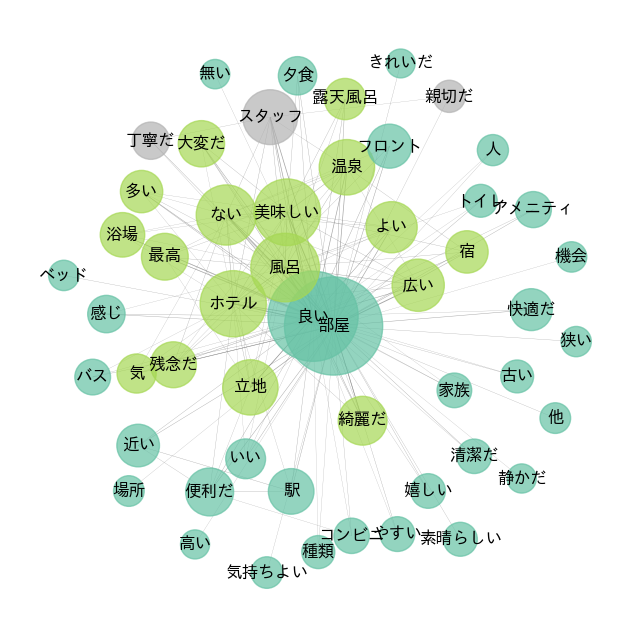

In [12]:
# 抽出語の出現回数(ノードの大きさ)を取得する
word_counts = cross_75_df.sum(axis=0).values

# 共起行列(共起度)で共起ネットワーク図を作成する
gssm_utils.plot_cooccur_network(cooccur_75_df, word_counts, cooccur_75_df.values.max() * 0.05)

#### (b) 共起ネットワーク (Jaccard 係数が上位のエッジを残す)

pyvis.html


<Figure size 800x800 with 0 Axes>

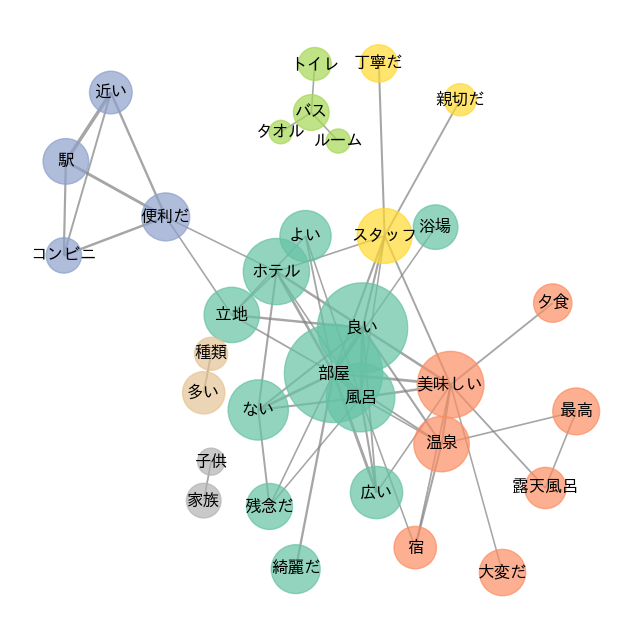

In [13]:
# 共起行列の中身を Jaccard 係数に入れ替える
jaccard_75_df = gssm_utils.jaccard_coef(cooccur_75_df, cross_75_df)

# 抽出語の出現回数(ノードの大きさ)を取得する
word_counts = cross_75_df.sum(axis=0).values

# 共起行列(Jaccard係数)で共起ネットワーク図を作成する
gssm_utils.plot_cooccur_network(jaccard_75_df, word_counts, np.sort(jaccard_75_df.values.reshape(-1))[::-1][60], pyvis=True)

### 1.5 対応分析

「文書-抽出語」 表を確認する

In [14]:
# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df.head())

(9616, 75)


表層                 部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  お湯  徒歩  \
カテゴリー  エリア   文書ID                                               ...           
A_レジャー 01_登別 1      0   1    0   0     0   0   0     0   0   0  ...   0   0   
             2      1   0    0   0     0   0   0     0   0   0  ...   0   1   
             3      1   1    1   0     0   1   1     1   0   0  ...   0   0   
             4      1   0    0   0     1   0   0     0   0   0  ...   0   0   
             5      0   1    1   0     0   0   0     0   0   0  ...   0   0   

表層                 ありがたい  タオル  少ない  女性  楽しい  安い  ルーム  水  
カテゴリー  エリア   文書ID                                        
A_レジャー 01_登別 1         0    0    0   0    0   0    0  0  
             2         0    0    0   0    0   0    0  0  
             3         0    0    0   0    0   0    0  0  
             4         0    0    0   0    1   0    0  0  
             5         0    0    0   0    0   0    0  1  

[5 rows x 75 columns]

「外部変数-抽出語」 クロス集計表を作成する

In [15]:
# 「カテゴリー」のクロス集計と「エリア」のクロス集計を連結する
aggregate_75_df = pd.concat(
    [
        cross_75_df.groupby(level='カテゴリー').sum(),
        cross_75_df.groupby(level='エリア').sum()
    ]
)

# DataFrame を表示する
print(aggregate_75_df.shape)
display(aggregate_75_df)

(12, 75)


表層,部屋,良い,ホテル,風呂,美味しい,ない,温泉,スタッフ,立地,よい,...,お湯,徒歩,ありがたい,タオル,少ない,女性,楽しい,安い,ルーム,水
A_レジャー,2325,2054,753,1474,1504,890,1292,856,550,648,...,235,141,149,132,185,152,235,110,71,128
B_ビジネス,2065,1649,1243,668,519,761,108,515,844,545,...,73,180,170,118,124,145,66,194,194,145
01_登別,435,398,157,301,269,185,267,118,57,109,...,46,15,32,32,36,26,41,16,19,28
02_草津,481,441,168,362,289,197,287,193,161,141,...,61,51,24,15,39,22,49,26,11,31
03_箱根,510,450,166,287,351,188,220,195,57,142,...,45,24,32,28,43,38,52,15,20,28
04_道後,380,366,218,190,202,150,257,103,164,136,...,29,22,30,34,27,29,28,38,15,17
05_湯布院,519,399,44,334,393,170,261,247,111,120,...,54,29,31,23,40,37,65,15,6,24
06_札幌,399,324,263,118,145,142,27,102,170,105,...,12,35,38,27,18,22,21,33,37,21
07_名古屋,388,334,243,147,95,161,26,125,145,115,...,20,33,33,25,34,34,11,36,38,30
08_東京,416,333,224,133,80,155,15,99,170,96,...,19,32,35,21,19,34,9,39,39,29


#### (a) 対応分析プロット (ライブラリ mca を使用)

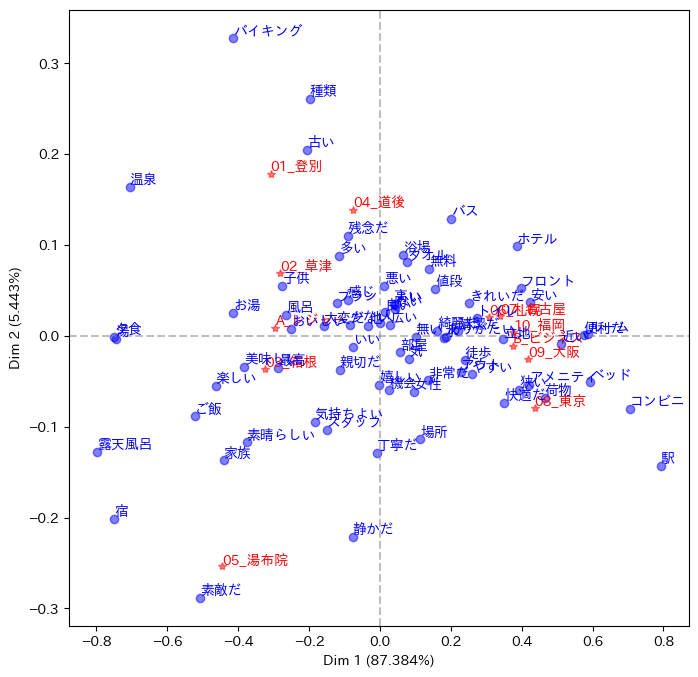

In [16]:
# 必要ライブラリのインポート
import mca

# ライブラリ mca による対応分析
ncols = aggregate_75_df.shape[1]
mca_ben = mca.MCA(aggregate_75_df, ncols=ncols, benzecri=False)

# 行方向および列方向の値を取り出す
row_coord = mca_ben.fs_r(N=2)
col_coord = mca_ben.fs_c(N=2)

# 固有値を求める
eigenvalues = mca_ben.L
total = np.sum(eigenvalues)
# 寄与率を求める
explained_inertia = 100 * eigenvalues / total

# 行方向および列方向のラベルを取得する
row_labels = aggregate_75_df.index
col_labels = aggregate_75_df.columns

# プロットする
gssm_utils.plot_coresp(row_coord, col_coord,row_labels, col_labels, explained_inertia)

#### (b) 対応分析プロット (カイ2乗値を手計算してプロットする)

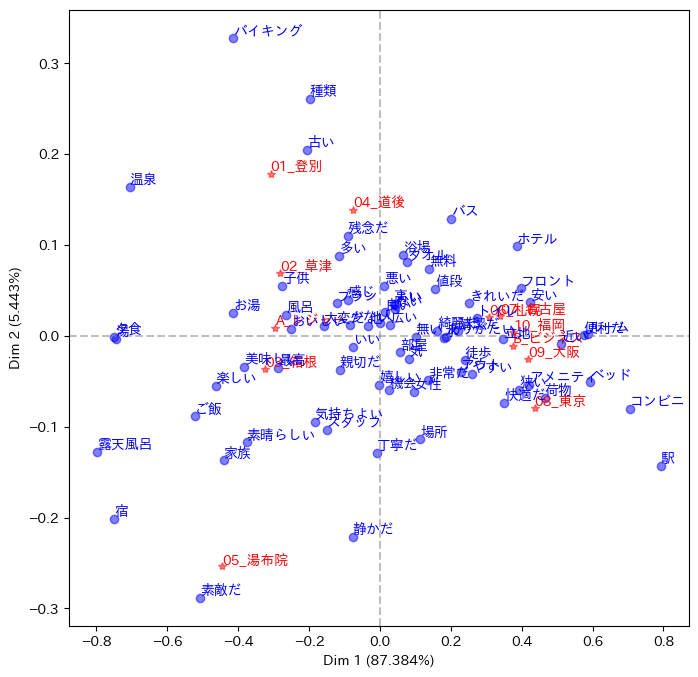

In [17]:
table_N = aggregate_75_df.values
row_sum = table_N.sum(axis=1)
col_sum = table_N.sum(axis=0)
n = aggregate_75_df.values.sum()

# カイ2乗値を求める
expected = np.outer(row_sum, col_sum) / n
chisq = np.square(table_N - expected) / expected
residuals = (table_N - expected) / np.sqrt(expected)

# Standardized residuals
residuals = residuals / np.sqrt(n)

# Number of dimensions
nb_axes = min(residuals.shape[0]-1, residuals.shape[1]-1)

# Singular value decomposition
U, s, V = np.linalg.svd(residuals, full_matrices=True)
sv = s[:nb_axes]
u = U[:, :nb_axes]
v = V[:nb_axes, :]

# row mass
row_mass = row_sum / n

# row coord = u * sv /sqrt(row.mass)
row_coord = (u * sv) / np.sqrt(row_mass)[:, np.newaxis]

# col mass
col_mass = col_sum / n

# row coord = sv * vT /sqrt(col.mass)
col_coord = (sv * v.T) / np.sqrt(col_mass)[:, np.newaxis]

# 固有値を求める
eige_nvalue = s ** 2

# 寄与率を求める
explained_inertia = 100 * eige_nvalue / sum(eige_nvalue)

# 行方向および列方向のラベルを取得する
row_labels = aggregate_75_df.index
col_labels = aggregate_75_df.columns

# プロットする
gssm_utils.plot_coresp(row_coord, col_coord,row_labels, col_labels, explained_inertia)

#### (c) 対応分析プロット (共起頻度のままプロットする)

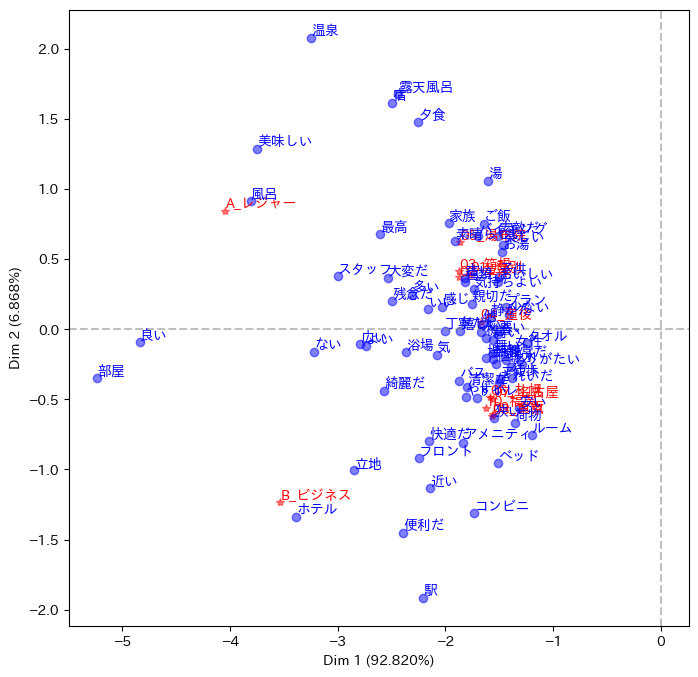

In [18]:
import numpy as np

table_N = aggregate_75_df.values
table_P = table_N / aggregate_75_df.values.max()

# Singular value decomposition
U, s, V = np.linalg.svd(table_P, full_matrices=True)
sv = s[:nb_axes]
u = U[:, :nb_axes]
v = V[:nb_axes, :]

# row mass
row_mass = row_sum / n

# row coord = u * sv /sqrt(row.mass)
row_coord = (u * sv) / np.sqrt(row_mass)[:, np.newaxis]

# col mass
col_mass = col_sum / n

# row coord = sv * vT /sqrt(col.mass)
col_coord = (sv * v.T) / np.sqrt(col_mass)[:, np.newaxis]

# 固有値を求める
eige_nvalue = s ** 2

# 寄与率を求める
explained_inertia = 100 * eige_nvalue / sum(eige_nvalue)

# 行方向および列方向のラベルを取得する
row_labels = aggregate_75_df.index
col_labels = aggregate_75_df.columns

# プロットする
gssm_utils.plot_coresp(row_coord, col_coord,row_labels, col_labels, explained_inertia)

#### (d) PCAプロット (共起頻度のままプロットする)

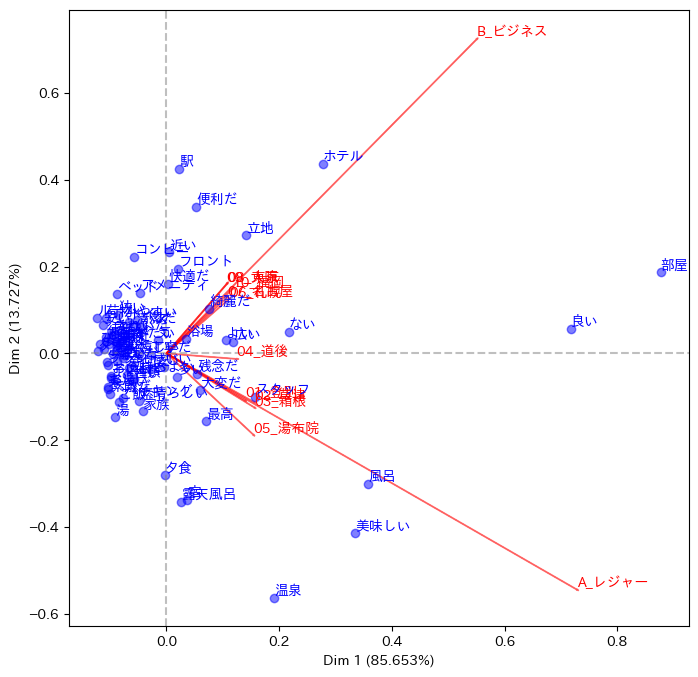

In [19]:
# 必要ライブラリのインポート
from sklearn.decomposition import PCA

table_N = aggregate_75_df.values

# ライブラリ PCA による主成分分析
pca = PCA()

reduced = pca.fit_transform(table_N.T)
coeff = np.transpose(pca.components_)
var_ratio = pca.explained_variance_ratio_

scalex = 1.0 / (reduced[:,0].max() - reduced[:,0].min())
scaley = 1.0 / (reduced[:,1].max() - reduced[:,1].min())
reduced[:,0] *= scalex
reduced[:,1] *= scaley

# プロットする
gssm_utils.plot_pca(coeff, reduced, row_labels, col_labels, var_ratio)

#### (e) PCAプロット (カイ2乗値をプロットする)

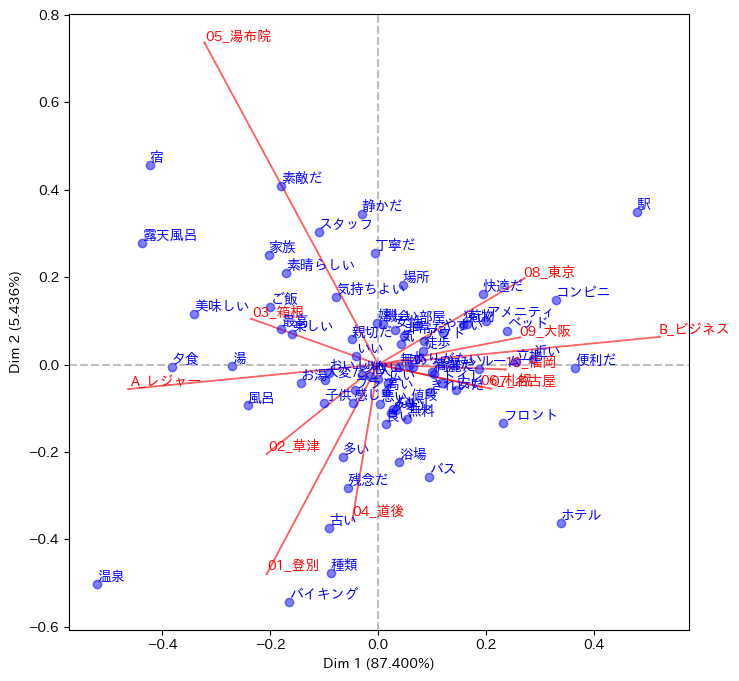

In [20]:
# 必要ライブラリのインポート
from sklearn.decomposition import PCA

import numpy as np

table_N = aggregate_75_df.values
row_sum = table_N.sum(axis=1)
col_sum = table_N.sum(axis=0)
n = aggregate_75_df.values.sum()

# カイ2乗値を求める
expected = np.outer(row_sum, col_sum) / n
chisq = np.square(table_N - expected) / expected
residuals = (table_N - expected) / np.sqrt(expected)

# Standardized residuals
residuals = residuals / np.sqrt(n)

# ライブラリ PCA による主成分分析
pca = PCA()

reduced = pca.fit_transform(residuals.T)
coeff = np.transpose(pca.components_)
var_ratio = pca.explained_variance_ratio_

scalex = 1.0 / (reduced[:,0].max() - reduced[:,0].min())
scaley = 1.0 / (reduced[:,1].max() - reduced[:,1].min())
reduced[:,0] *= scalex
reduced[:,1] *= scaley

# プロットする
gssm_utils.plot_pca(coeff, reduced, row_labels, col_labels, var_ratio)

---

## 【演習】 2021~2022 データセット

### 2.0 【演習】 事前準備 (定義済み関数の読み込み)

以下のセルを**修正せず**に実行してください

In [21]:
import warnings
warnings.simplefilter('ignore')

import gssm_utils

### 2.1 【演習】 データのダウンロード

以下のデータがダウンロード済みです

| ファイル名 | 件数 | データセット | 備考 |
| --- | --- | --- | --- |
| rakuten-1000-2021-2022.xlsx.zip | 10,000 | •レジャー+ビジネスの 10エリア<br>•エリアごと 1,000件 (ランダムサンプリング)<br>•期間: 2021/1~2022/12 | 演習用 (年度で比較する場合など) |

In [22]:
# rakuten-1000-2021-2022.xlsx.zip をダウンロードする
FILE_ID = "1ru2f4vasZBDo6Rt1B9OwMN-eksyqAl7i"
!gdown --id {FILE_ID}
!unzip -o rakuten-1000-2021-2022.xlsx.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ru2f4vasZBDo6Rt1B9OwMN-eksyqAl7i
To: /content/rakuten-1000-2021-2022.xlsx.zip
100% 2.44M/2.44M [00:00<00:00, 181MB/s]
Archive:  rakuten-1000-2021-2022.xlsx.zip
  inflating: rakuten-1000-2021-2022.xlsx  


### 2.2 【演習】 データの読み込み (DataFrame型)

In [23]:
import numpy as np
import pandas as pd

all_df = pd.read_excel("rakuten-1000-2021-2022.xlsx")
print(all_df.shape)
display(all_df.head())

(10000, 18)


,カテゴリー,エリア,施設番号,施設名,コメント,総合,サービス,立地,部屋,設備・アメニティ,風呂,食事,旅行の目的,同伴者,宿泊年月,投稿者,年代,性別
0,A_レジャー,01_登別,78111,虎杖浜天然温泉「旅人の湯」ホテルルートイン東室蘭駅前,ＪＲ東室蘭駅に近い立地でビジネスに便利です。駐車場も広くて車での利用にも便利です。結構広い大...,4,4,5,4,4.0,4.0,4.0,ビジネス,一人,44256,ごしごし０１,40代,男性
1,A_レジャー,01_登別,30109,登別温泉 第一滝本館,お部屋は、古かったですがきちんと清掃がいき届いていて気持ちが良かったです。海の隣りでの露天風...,4,5,5,5,3.0,4.0,4.0,レジャー,家族,44835,mitu0430,50代,女性
2,A_レジャー,01_登別,37379,登別温泉 名湯の宿 パークホテル雅亭,5/4に1泊で利用させていただきました。案内、フロント(チェックイン・チェックアウト)、バイ...,4,4,4,4,4.0,4.0,4.0,レジャー,家族,44682,あっちゃん3939,50代,女性
3,A_レジャー,01_登別,177998,民宿 元和や,久しぶりの宿泊に胸躍る気持ちで伺いました。オーナーご夫婦のお人柄に、改めて癒された時間でした...,5,5,5,5,5.0,5.0,5.0,レジャー,家族,44682,投稿者,na,na
4,A_レジャー,01_登別,28637,登別温泉 登別万世閣,直行便のバスがあったので利用したが、次は無い。まずバイキングで逐一手袋を強制される。スタッフ...,2,2,4,1,1.0,4.0,2.0,レジャー,一人,44896,楽丸くん0333,40代,男性


### 2.3 【演習】 「文書-抽出語」表 を作成する

コメント列から単語を抽出する (単語を品詞「名詞」「形容詞」「未知語」で絞り込む)

In [24]:
# ToDo: 1.3 の該当コードをコピーして貼り付けて実行してください

抽出語の出現頻度をカウントする

In [25]:
# ToDo: 1.3 の該当コードをコピーして貼り付けて実行してください

単語IDを紐つける (出現回数 Top 150語のみ抽出する)

In [26]:
# ToDo: 1.3 の該当コードをコピーして貼り付けて実行してください

「文書-抽出語」表 を作成する

In [27]:
# ToDo: 1.3 の該当コードをコピーして貼り付けて実行してください

「文書-抽出語」 表を {0,1} に変換する

In [28]:
# ToDo: 1.3 の該当コードをコピーして貼り付けて実行してください

### 2.4 【演習】 共起ネットワーク

共起度行列を作成する (抽出語-抽出語)

In [29]:
# ToDo: 1.4 の該当コードをコピーして貼り付けて実行してください

#### (b) 共起ネットワーク (Jaccard 係数が上位のエッジを残す)

In [30]:
# ToDo: 1.4 (b) の該当コードをコピーして貼り付けて実行してください

### 2.5 【演習】 対応分析

「文書-抽出語」 表を確認する

In [31]:
# ToDo: 1.5 の該当コードをコピーして貼り付けて実行してください

「外部変数-抽出語」 クロス集計表を作成する

In [32]:
# ToDo: 1.5 の該当コードをコピーして貼り付けて実行してください

#### (a) 対応分析プロット (ライブラリ mca を使用)

In [33]:
# ToDo: 1.5 (a)のコードをコピーして貼り付けて実行してください